In [1]:
import pandas as pd
from pandas import Series, DataFrame, Panel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import sklearn
import scipy
import scipy.ndimage
from PIL import Image
%matplotlib inline

In [2]:
# Загружаем MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

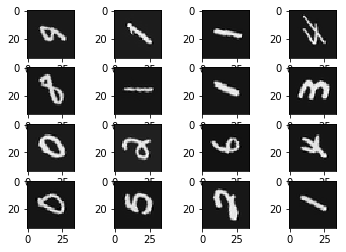

In [4]:
import scipy
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = scipy.ndimage.rotate(X[np.random.randint(0, X.shape[0]),0], 75)
    #print(I.shape)
    plt.imshow(I, cmap='gray')
#(X[np.random.randint(0, X.shape[0]),0])

In [5]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)
Y_enc = np.zeros((len(Y), 10))
for i in range(len(Y)):
  Y_enc[i, Y[i]] = 1
Y_enc

original [5 0 4 ... 4 5 6]


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('conv_1', nn.Conv2d(1, 32, kernel_size=(3,3), stride=1))
        self.net.add_module('relu_1', nn.ReLU())
        self.net.add_module('conv_2', nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)) 
        self.net.add_module('relu_2', nn.ReLU())
        self.net.add_module('drop_1', nn.Dropout(0.1))                  
        self.fc1 = nn.Linear(64*24*24, 128)
        self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 64 * 24 * 24)
        x = self.fc2(self.drop2(F.relu(self.fc1(x))))
        return x


class MLPNet(nn.Module):

    def __init__(self):
        super(MLPNet, self).__init__()
        self.net = nn.Sequential()                 
        self.fc1 = nn.Linear(28*28, 200)
        self.drop2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 28*28)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x


## Функция обучения модели

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

def fit_net(c_epoch, net, X, Y):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    net = net.train()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_train[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_train[batch_idxs]).long().to(DEVICE))
            y_pred = F.softmax(net(x), -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    return net

def experiment_vanilla(net, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [8]:
def experiment_ensemble(nets, X, Y, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    for i in range(len(nets)):
        nets[i] = nets[i].to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for net in nets:
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= len(nets)

            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [9]:
def fit_net_T(c_epoch, net, X, Y):
    loss_fn = torch.nn.NLLLoss()
    

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(DEVICE)
    
    class T_net(nn.Module):
        def __init__(self):
            super(T_net, self).__init__()
            self.T = nn.Parameter(torch.FloatTensor([1.]))
            
        def forward(self, x):
            return F.log_softmax(Variable(net(x))*self.T, -1)
    t_net = T_net().to(DEVICE)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test, test_size=0.7, random_state=97)
    optimizer = torch.optim.Adam(t_net.parameters(), lr=learning_rate)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_val.shape[0])
        loss_acc = 0
        nbatches = X_val.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_val[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_val[batch_idxs]).long().to(DEVICE))
            y_pred = t_net(x) # F.log_softmax(Variable(net(x))/T, -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('T optimization: Do epoch %s with loss %s T = %s' % (iter, avg_epoch_loss, 1./t_net.T.data.item()))
        loss_curve.append(avg_epoch_loss)
    return t_net.T.data.item()

    
    

def experiment_temperature(net, X, Y, T, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]*T))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

In [10]:
def experiment_dropout(net, X, Y, n_iter=10, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for it in range(n_iter):
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= n_iter
            
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

### Обучаем модели


In [11]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_v = net_v.eval()
loss_curve_translate_vanilla , brier_curve_translate_vanilla = experiment_vanilla(model_v, X,Y, translate=True)
loss_curve_rotate_vanilla , brier_curve_rotate_vanilla = experiment_vanilla(model_v, X,Y, rotate=True)
loss_curve_blur_vanilla , brier_curve_blur_vanilla = experiment_vanilla(model_v, X,Y, blur=True)

Do epoch 0 with loss 1.855602708724023
Do epoch 1 with loss 1.5121061623032581
Do epoch 2 with loss 1.4983343881298363
Do epoch 3 with loss 1.4926720527973973
Do epoch 4 with loss 1.4900674962409695
Do epoch 5 with loss 1.4862327503493618
Do epoch 6 with loss 1.4828719530586005
Do epoch 7 with loss 1.4829898926989442
Do epoch 8 with loss 1.48211821329172
Do epoch 9 with loss 1.4799884348181411


In [12]:
nets = []
for i in range(10):
    net = LeNet()
    nets.append(fit_net(10, net, X, Y).eval())
loss_curve_translate_ensemble , brier_curve_translate_ensemble = experiment_ensemble(nets, X,Y, translate=True)
loss_curve_rotate_ensemble , brier_curve_rotate_ensemble = experiment_ensemble(nets, X,Y, rotate=True)
loss_curve_blur_ensemble , brier_curve_blur_ensemble = experiment_ensemble(nets, X,Y, blur=True)

Do epoch 0 with loss 1.7550380642007786
Do epoch 1 with loss 1.52343245257902
Do epoch 2 with loss 1.5058987062715896
Do epoch 3 with loss 1.5003804482703296
Do epoch 4 with loss 1.4946081359159014
Do epoch 5 with loss 1.4915014900195254
Do epoch 6 with loss 1.490419743081509
Do epoch 7 with loss 1.4877391451808033
Do epoch 8 with loss 1.485841593558382
Do epoch 9 with loss 1.48462422765464
Do epoch 0 with loss 1.6657077100243727
Do epoch 1 with loss 1.5112656908786566
Do epoch 2 with loss 1.5005494681329716
Do epoch 3 with loss 1.493901074635382
Do epoch 4 with loss 1.4899826178852258
Do epoch 5 with loss 1.4889808904703024
Do epoch 6 with loss 1.485751254126701
Do epoch 7 with loss 1.4835858213428772
Do epoch 8 with loss 1.4818049264235256
Do epoch 9 with loss 1.4810126898500824
Do epoch 0 with loss 1.6539993942869948
Do epoch 1 with loss 1.5149581486005874
Do epoch 2 with loss 1.5049789169721408
Do epoch 3 with loss 1.5002470885314614
Do epoch 4 with loss 1.4937392742815252
Do epoch

In [14]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_v = net_v.eval()
T = fit_net_T(20, model_v, X, Y)
loss_curve_translate_temp, brier_curve_translate_temp = experiment_temperature(model_v, X,Y,T, translate=True)
loss_curve_rotate_temp, brier_curve_rotate_temp = experiment_temperature(model_v, X,Y,T, rotate=True)
loss_curve_blur_temp , brier_curve_blur_temp = experiment_temperature(model_v, X,Y,T, blur=True)

Do epoch 0 with loss 1.6754511042806497
Do epoch 1 with loss 1.5100124197246434
Do epoch 2 with loss 1.496555609143432
Do epoch 3 with loss 1.4903686983153495
Do epoch 4 with loss 1.4872145862313584
Do epoch 5 with loss 1.4847686092058818
Do epoch 6 with loss 1.4815038498830437
Do epoch 7 with loss 1.4804658051600155
Do epoch 8 with loss 1.479216172508616
Do epoch 9 with loss 1.479958074652497
T optimization: Do epoch 0 with loss 0.20370705110762763 T = 1.0065834763563024
T optimization: Do epoch 1 with loss 0.2024962288803991 T = 1.0128680949631454
T optimization: Do epoch 2 with loss 0.20125605220203907 T = 1.0188040619742125
T optimization: Do epoch 3 with loss 0.20006975980592034 T = 1.0252986448656158
T optimization: Do epoch 4 with loss 0.19887065454332375 T = 1.0311875991100075
T optimization: Do epoch 5 with loss 0.19768894986499902 T = 1.037708596720841
T optimization: Do epoch 6 with loss 0.19652877457674406 T = 1.0440077483456607
T optimization: Do epoch 7 with loss 0.195349

In [16]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
loss_curve_translate_drop, brier_curve_translate_drop = experiment_dropout(net_v, X,Y, translate=True)
loss_curve_rotate_drop, brier_curve_rotate_drop = experiment_dropout(net_v, X,Y, rotate=True)
loss_curve_blur_drop , brier_curve_blur_drop = experiment_dropout(net_v, X,Y, blur=True)

Do epoch 0 with loss 1.661481374904657
Do epoch 1 with loss 1.514196847476632
Do epoch 2 with loss 1.501001268401662
Do epoch 3 with loss 1.4953412814794502
Do epoch 4 with loss 1.490473871765157
Do epoch 5 with loss 1.4879881984934547
Do epoch 6 with loss 1.4869179794642704
Do epoch 7 with loss 1.4835057421512543
Do epoch 8 with loss 1.484118552453265
Do epoch 9 with loss 1.48087060029867


 ## Результаты

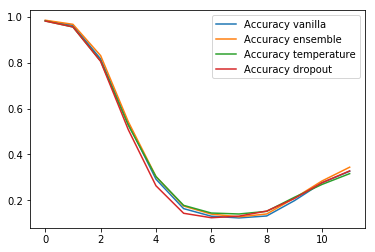

In [17]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_rotate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_rotate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_rotate_temp,label="Accuracy temperature")
ax.plot(loss_curve_rotate_drop,label="Accuracy dropout")
ax.legend()
plt.show()

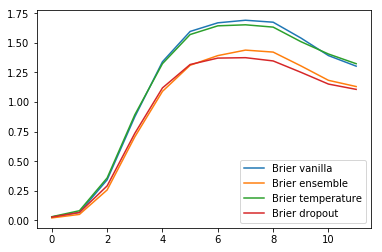

In [18]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_rotate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_rotate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_rotate_temp,label="Brier temperature")
ax.plot(brier_curve_rotate_drop,label="Brier dropout")
ax.legend()
plt.show()

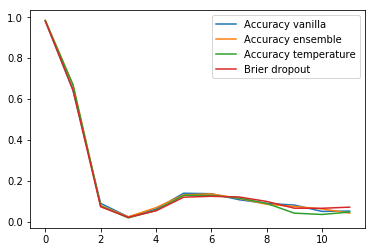

In [23]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_translate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_translate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_translate_temp,label="Accuracy temperature")
ax.plot(loss_curve_translate_drop,label="Brier dropout")
ax.legend()
plt.show()

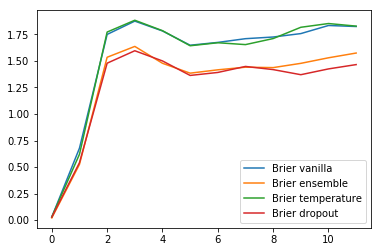

In [24]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_translate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_translate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_translate_temp,label="Brier temperature")
ax.plot(brier_curve_translate_drop,label="Brier dropout")
ax.legend()
plt.show()

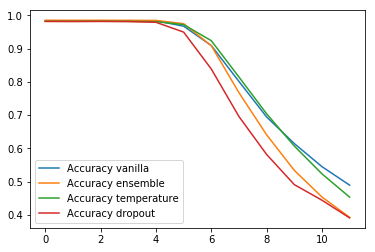

In [21]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_blur_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_blur_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_blur_temp,label="Accuracy temperature")
ax.plot(loss_curve_blur_drop,label="Accuracy dropout")
ax.legend()
plt.show()

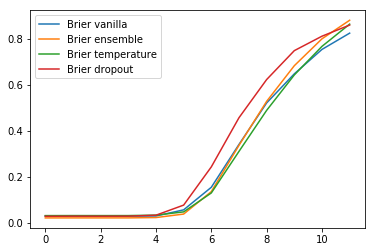

In [26]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_blur_vanilla,label="Brier vanilla")
ax.plot(brier_curve_blur_ensemble,label="Brier ensemble")
ax.plot(brier_curve_blur_temp,label="Brier temperature")
ax.plot(brier_curve_blur_drop,label="Brier dropout")
ax.legend()
plt.show()